\\ the example is taken from zarchan 375:
    estimate the ballistic coefficient of a target.
\\
# kalman filter
    <br> estimates the ballistic coefficient of vertically falling target. 
* ## program structure
* ###   main loop - radar simulation 
* #####    functions
        simulate the ballistic target (traveling in vertical motion)
        simulate the radar measures
        run the system loop
* #####    parameters 
        initial conditions 
        optimization variables 
* ###   target class
* #####    parameters 
        data point
        drag coefficient ( ballistic paramter ) 
* ###   radar class
* #####  parameters 
        measurement noise 
        sample time
        kalman filter
* #####    functions
        measure
* ###   filter class 
* #####    parameters 
        process matrix
        process noise matrix
        measurement matrix
        measurement noise matrix
* #####    functions
        predict
        correct (solves ricatti for the filter gains).









In [1]:
# some setup 

import numpy as np
from scipy.integrate import solve_ivp, odeint

import matplotlib.pyplot as plt

import os, sys
sys.path.append(os.path.join(os.getcwd(), os.pardir))

import C4dynamics as c4d
from m_target import c_target

# import importlib
# importlib.reload(c4d)


In [2]:
# initial conditions 
z0 = 100000 * c4d.params.ft2m
v0 = -6000 * c4d.params.ft2m
a0 = 0
beta = 500 * c4d.params.lbft2kgm

# sim parameters 
dt = 1e-3
tf = 30 

# objects definition 
tgt = c_target([z0, v0, a0], beta)
rdr = c4d.seekers.dzradar([z0 + 25 * c4d.params.ft2m
                     , v0 - 150 * c4d.params.ft2m
                     , beta + 300 * c4d.params.lbft2kgm]
                    , c4d.filters.filtertype.ex_kalman
                    , 50e-3)


# main loop 
for t in np.arange(0, tf, dt):
    
    ''' simulate target motion '''
    y = odeint(c_target.deriv, [tgt.z, tgt.vz], t + [0, dt], args = (tgt, )) 
    # if y[-1, 0] <= 0:
    #     break
    tgt.z, tgt.vz = y[-1, :]
    tgt.data = np.concatenate((tgt.data, np.array([[tgt.z, tgt.vz, 0, 0]])), axis = 0)
    
    ''' take radar measure '''
    # tgt_dist = tgt.z + rdr.vk * np.random.randn(1) #  0.86217 # 
    rdr.measure(tgt.z)
    tgt_measure = rdr.filter(t)

# zmask = tgt.data[:, 0] < 100000


dy = c_target.deriv(tgt.data, 0, tgt) 
tgt.data[:, 2] = np.asarray(dy).T[:, 0]
tgt.data[:, 3] = np.ones(len(tgt.data)) * beta

In [3]:


# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
# plt.rcParams['text.usetex'] = True

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# 
# plt.show() plots all the figures present in the state machine. Calling it only at the end of 
#       the script, ensures that all previously created figures are plotted.
# Now you need to make sure that each plot indeed is created in a different figure. That can be 
#       achieved using plt.figure(fignumber) where fignumber is a number starting at index 1.
#

Text(0.5, 0.8, '$\\beta$')

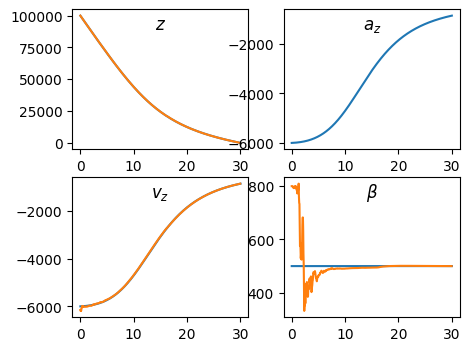

In [4]:

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(np.arange(0, tf, dt), tgt.data[0 : -1, 0])
axs[0, 0].plot(rdr.data[:, 0], rdr.data[:, 1])
axs[0, 0].set_title('$z$', y = 0.8) # (r'\textbf{z}', y = 0.8)

axs[0, 1].plot(np.arange(0, tf, dt), tgt.data[0 : -1, 2])
axs[0, 1].set_title('$a_z$', y = 0.8)

axs[1, 0].plot(np.arange(0, tf, dt), tgt.data[0 : -1, 1])
axs[1, 0].plot(rdr.data[:, 0], rdr.data[:, 2])
axs[1, 0].set_title('$v_z$', y = 0.8)

axs[1, 1].plot(np.arange(0, tf, dt), tgt.data[0 : -1, 3])
axs[1, 1].plot(rdr.data[:, 0], rdr.data[:, 3])
axs[1, 1].set_title(r'$\beta$', y = 0.8)

In [6]:
from matplotlib.patches import Circle
import os 

fol = 'fig'
if not os.path.exists(fol):
    os.makedirs(fol)

tgtbeta = tgt.data[:, 3]
rdrbeta = rdr.data[:, 3]
t = np.arange(0, tf, dt)
t_rdr = rdr.data[:, 0]
rdridx = 0
# if (1000 * t) % (1000 * obj.ts) > 1e-6 or t <= 0:
#   return
    
# Make an image every di time points, corresponding to a frame rate of fps
# frames per second.
# Frame rate, s-1
fps = 10
di = int(1 / fps / dt)
fig = plt.figure(figsize = (8.3333, 6.25), dpi = 72)
plt.ioff()
ax = fig.add_subplot(111)

for i in range(10200): # len(t)): # 3000): #
    if t_rdr[rdridx] == t[i]:
    # for t in np.arange(0, tf, dt):

        # print(i // di, '/', t.size // di)
        
        # Plot and save an image of the double pendulum configuration for time
        # point i.s
        # The pendulum rods.
        # ax.plot(0, 0, lw = 2, c = 'k')
        # ax.set_facecolor('indianred')
        
        # Circles representing the anchor point of rod 1, and bobs 1 and 2.
        c0 = Circle((t[i] * 100, tgtbeta[i]), 20, fc = 'r', zorder = 10)
        ax.add_patch(c0)
        # print(t[i] * 100, tgtbeta[i])
        
        c1 = Circle((t_rdr[rdridx] * 100, rdrbeta[rdridx]), 20, fc = 'b', ec = 'b', zorder = 10)
        # print(t_rdr[rdridx] * 100, rdrbeta[rdridx])
        ax.add_patch(c1)
        rdridx += 1
        if rdridx == len(t_rdr):
            break

        # c2 = Circle((x2[i], y2[i]), obj.r, fc = 'r', ec = 'r', zorder = 10)
        # ax.add_patch(c2)

        # # The trail will be divided into ns segments and plotted as a fading line.
        # s = max_trail // ns
        ns = 5 # 20
        max_trail = int(1 / dt)
        s = 1 # max_trail // ns

        # for j in range(ns):
        #     imin = i - (ns - j) * s
        #     if imin < 0:
        #         continue
        #     imax = imin + s + 1
        #     # The fading looks better if we square the fractional length along the
        #     # trail.
        #     alpha = (j / ns)**2
        #     ax.plot(t_rdr[imin : imax] * 100, rdrbeta[imin : imax], c = 'b', solid_capstyle = 'butt', lw = 2, alpha = alpha)

        # Centre the image on the fixed anchor point, and ensure the axes are equal
        ax.set_xlim(-50, 1000)
        ax.set_ylim(500 - 200, 500 + 400)
        ax.set_aspect('equal', adjustable = 'box')
        plt.axis('off')
        # plt.savefig(fol + '/_img{:04d}.png'.format(i//di), dpi = 72) # frames
        plt.savefig(fol + "/img_" + str(i), dpi = 72) # frames
        plt.cla() # clear axes 
# print('images saved in ' + fol)
plt.close(fig)
# plt.show()
        

_img_movie.gif is saved in d:\gh_repo\examples


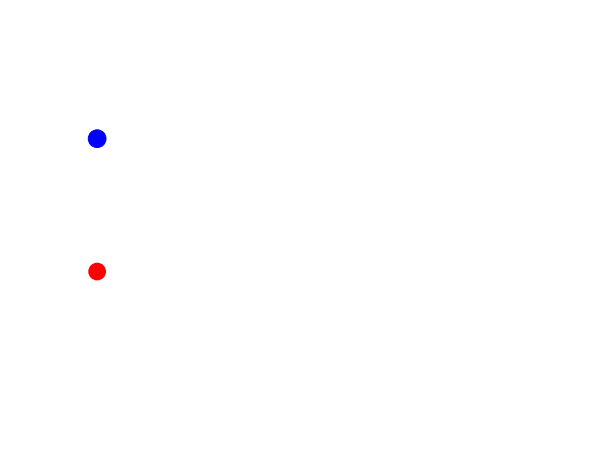

In [9]:
import importlib

from IPython.display import Image

# fol = 'fig'
# %mkdir -p $fol
# %mkdir $fol
c4d.tools.gen_gif(fol)

Image(filename = '_img_movie.gif') 